In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense, Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=False)) for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
train_df['hassalt'] = train_df['masks'].apply(lambda x: (x.max()!=0) * 1)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
z_max = train_df['z'].max()
z_min = train_df['z'].min()
z_dis = z_max - z_min
train_df['z'] = (train_df['z'] - z_min) / z_dis
step = 1 / z_dis

In [5]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [6]:
x_train, x_valid, msk_train, msk_val, y_train, y_valid, depth_train, depth_test = train_test_split(
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.hassalt.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [7]:
# aug_img = []
# aug_y = []
# augments = [
#     (0.5, HorizontalFlip(p=1)),
#     (0.5, VerticalFlip(p=1)),
#     (0.5, RandomRotate90(p=1)),
#     (0.5, Transpose(p=1)),
#     (0.5, ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)),
#     (0.5, GridDistortion(p=1)),
#     (0.5, OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)),
#     (0.5, RandomSizedCrop(p=1, min_max_height=(int(img_size_ori / 2), img_size_ori), height=img_size_ori, width=img_size_ori)),
# ]

# for ratio, aug in tqdm_notebook(augments):
#     selidx = np.random.choice(x_train.shape[0], int(x_train.shape[0] * ratio), replace=False)
#     for idx in tqdm_notebook(selidx):
#         augmented = aug(image=x_train[idx], mask=msk_train[idx])
#         aimg = augmented['image']
#         if len(aimg.shape) < 3:
#             aimg = aimg[...,np.newaxis]

#         aug_img.append(aimg)
#         aug_y.append(y_train[idx])

# aug_img = np.asarray(aug_img)
# aug_y = np.asarray(aug_y)
# x_train = np.append(x_train, aug_img, axis=0)
# y_train = np.append(y_train, aug_y, axis=0)
# print(x_train.shape)
# print(y_train.shape)

In [8]:
# x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
# y_train = np.append(y_train, y_train, axis=0)
# depth_train = np.append(depth_train, depth_train, axis=0)
# print(x_train.shape)
# print(y_train.shape)

In [9]:
# x_train = add_depth_bulk_act(x_train, depth_train, step)
# x_valid = add_depth_bulk_act(x_valid, depth_test, step)

In [10]:
def get_model(BASE_MODEL):
    from keras.preprocessing.image import ImageDataGenerator
    if BASE_MODEL=='VGG16':
        from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
    elif BASE_MODEL=='VGG19':
        from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
    elif BASE_MODEL=='RESNET52':
        from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
    elif BASE_MODEL=='InceptionV3':
        from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
    elif BASE_MODEL=='Xception':
        from keras.applications.xception import Xception as PTModel, preprocess_input
    elif BASE_MODEL=='DenseNet169': 
        from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
    elif BASE_MODEL=='DenseNet121':
        from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
    elif BASE_MODEL=='InceptionResNetV2':
        from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel, preprocess_input
    else:
        raise ValueError('Unknown model: {}'.format(BASE_MODEL))
        
    return PTModel, preprocess_input

In [11]:
from keras.applications.resnet50 import ResNet50

In [12]:
model = ResNet50(input_shape = (101,101,3), include_top = False, weights = 'imagenet')

/home/kownse/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:264: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [13]:
model.layers[6]

In [14]:
def train_classifier(base_name = 'RESNET52'):
    print(base_name)
    PTModel, preprocess_input = get_model(base_name)
    x_train_act = x_train
    x_val_act = x_valid
#     x_train_act = x_train.astype(np.float32)
#     for idx in range(len(x_train_act)):
#         x_train_act[idx] = preprocess_input(x_train_act[idx])
#     print(x_train_act.max())

#     x_val_act = x_valid.astype(np.float32)
#     for idx in range(len(x_val_act)):
#         x_val_act[idx] = preprocess_input(x_val_act[idx])

    inputshape = x_train_act.shape[1:]
    PTModel, preprocess_input = get_model(base_name)
    base_pretrained_model = PTModel(input_shape = inputshape, 
                                  include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False

    from keras import models, layers
    from keras.optimizers import Adam
    img_in = layers.Input(inputshape, name='Image_RGB_In')
    x = base_pretrained_model(img_in)
#     x = layers.BatchNormalization()(x)
#     x = layers.GlobalMaxPooling2D()(x)
    x = layers.Flatten(name='flatten')(x)

    x = Dense(256)(x)
    x = BatchActivate(x)
    x = Dropout(0.5)(x)

    x = Dense(64)(x)
    x = BatchActivate(x)
    x = Dropout(0.5)(x)

    out_layer = layers.Dense(1, activation = 'sigmoid')(x)
    class_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

    class_model.compile(optimizer = Adam(lr=0.01), 
                       loss = 'binary_crossentropy',
                       metrics = ['binary_accuracy'])

    batch_size = 32
    basic_name = '../model/classifier/{}'.format(base_name)
    save_model_name = basic_name + '.model'
    submission_file = basic_name + '.csv'

    print(save_model_name)
    print(submission_file)


    board = keras.callbacks.TensorBoard(log_dir='log/classifier/{}'.format(base_name),
                           histogram_freq=0, write_graph=True, write_images=False)
    early_stopping = EarlyStopping(monitor='val_binary_accuracy', mode = 'max',patience=5, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_binary_accuracy', 
                                       mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', mode = 'max',factor=0.5, patience=2, min_lr=0.00001, verbose=1)

    epochs = 200

    history = class_model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[board, early_stopping, reduce_lr, model_checkpoint],
                        verbose=1)
    
    model = load_model('../model/classifier/Xception.model',custom_objects={'my_iou_metric': my_iou_metric})
    

In [15]:
model_lst = ['VGG16']
for base_model in model_lst:
    train_classifier(base_model)

VGG16
151.061
../model/classifier/VGG16.model
../model/classifier/VGG16.csv
Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 7s 2ms/step - loss: 0.4163 - binary_accuracy: 0.8147 - val_loss: 0.3189 - val_binary_accuracy: 0.8662

Epoch 00001: val_binary_accuracy improved from -inf to 0.86625, saving model to ../model/classifier/VGG16.model
Epoch 2/200
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3014 - binary_accuracy: 0.8728 - val_loss: 0.3233 - val_binary_accuracy: 0.8538

Epoch 00002: val_binary_accuracy did not improve from 0.86625
Epoch 3/200
3200/3200 [==============================] - 5s 2ms/step - loss: 0.2629 - binary_accuracy: 0.8875 - val_loss: 0.3117 - val_binary_accuracy: 0.8650

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00003: val_binary_accuracy did not improve from 0.86625
Epoch 4/200
3200/3200 [==============================] - 5s 2ms/step - loss: 0.18

In [16]:
model = load_model('../model/classifier/Xception.model',custom_objects={'my_iou_metric': my_iou_metric})

/home/kownse/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [17]:
layer = model.layers[0]

In [18]:
layer.trainable = True

In [19]:
# model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
#                                                    'lovasz_loss': lovasz_loss})




[0.61    0.61    0.61    0.61    0.61    0.61    0.61    0.61    0.61
 0.61    0.61    0.61    0.61    0.61    0.61    0.61    0.4425  0.435
 0.4325  0.42625 0.4225  0.42    0.415   0.41125 0.42375 0.4175  0.4125
 0.41125 0.40875 0.405   0.40375]
Threshold vs IoU (-0.8472978603872036, 0.61)


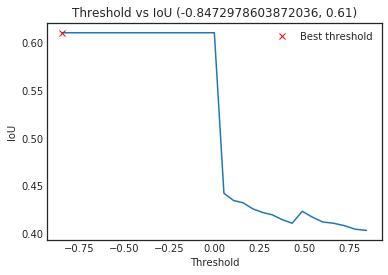

In [20]:
preds_valid = model.predict(x_valid)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
title = "Threshold vs IoU ({}, {})".format(threshold_best, iou_best)
print(title)
plt.title(title)
plt.legend()

In [21]:
# x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

# preds_test = predict_result(model,x_test,img_size_target)